# CLASSIFICATION OF UNDESIRABLE EVENTS IN OIL WELL OPERATIONS IN DOWNSTREAM

BY
  - **GILBERT VICTOR**(Lead)
  - **OVIE IBOYITIE**
  - **DANIEL NGWU**
  - **PAUL NWACHUKWU**

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#frameworks">Libraries and Frameworks Used</a></li>
<li><a href="#extraction">Data Extraction and Aggegation</a></li>

<li><a href="#cleaning">Data Cleaning</a></li>
<li><a href="#eda">Exploratory Data Aanlysis</a></li>

<li><a href="#mdd">Model Development</a></li>
<li><a href="#mde">Model Evaluation</a></li>
<li><a href="#conclusions">Report</a></li>
<li><a href="#references">References</a></li>
<li><a href="#limitations">Limitations</a></li>
</ul>

<a id='intro'></a> 
## Introduction

The identification, prediction and classification of unwanted unpleasant events in Oil well operations are task that are important and carried out and/or monitored by humans . 

The task of responding to abnormal events in a process include the prompt detection of an abnormal event, the diagnosis of its underlying causes, and the implementation of the necessary control decisions and actions to return the process to a normal, secure, and functional condition. 

A search approach that has been employed successfully, particularly in recent years, is the use of machine learning algorithms to data gathered from processes. There have been increasing demands for greater operational safety, productivity, quality, and energy efficiency

Oil wells are prone to undesirable conditions such as Severe Slugging, Flow Instability, etc. 
Well intervention process takes time and a lot of resources ,
The detection and predictions of unwanted occurrences in oil and gas wells can lower maintenance costs and help minimize production losses, environmental disasters, and human fatalities. This work presents a rich dataset with cases of eight types of unpleasant occurrences, each of which is distinguished by eight process characteristics, to help contribute to providing prior knowledge about undesirable events for diagnostic algorithms in offshore naturally flowing wells. 

<a id='frameworks'></a>
## Libraries and Frameworks Used

In [ ]:
## IMPORT RELEVANT LIBRARIES

# DATA EXTRACTION
import glob
import os

# DATA MANIPULATION
import numpy as np      # For Numeric computations
import pandas as pd     # For Dataframe manipulation

# DATA VISUALIZATION
from    missingno import matrix
from    skimpy    import skim
import  matplotlib.pyplot as plt
import  seaborn as sns 

# MACHINE LEARNING LIBRARIES 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Normalization , Dropout , BatchNormalization

# MODEL EVALUATION
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, jaccard_score, f1_score

tf.random.set_seed(1234)  # applied to achieve consistent results

: 

# Data Information 

#### Class information
<img src="data types.jpg">

<a id='extraction'></a> 
## DATA EXTRACTION 

> - Collect the directories of all files 
> - Obtain each data
> - Aggregate data by choosen metric 
>     - Time range - 1 Minutes
>     - Aggregator - Median
> - Join all in a data frame using a loop and the pd.concat statement

In [2]:
# Establish root dir wher files resides
# This depends on your PC, Find the directory to the 3W folder
root_dir = r"C:\Users\Ovie R. Iboyitie\CypherCrescent\3W"

# Get all file Diretiories 
directiories = []
for i in range(0,9):
    directiories.append(root_dir  + f'\\{i}')

# Extract all file names directories 
files = []
for dir_name in directiories:
    files = files + glob.glob(os.path.join(dir_name, "*.csv"))

In [3]:
def data_collect(directory, time ,style ):
    '''
    This code aggregates each individual file 
    styles include - median, midrange, max, min, mode
    '''
    return pd.read_csv(directory, parse_dates= [0]).resample(time, on = 'timestamp').agg(style).reset_index()
    

def joinall(files, time = '10T', style = 'median'):
    '''
    This code block empasizes om joining each aggregated dataframe together
    '''
    ct = 0
    
    for dir_ in files:    
        if ct == 0 :
            df = data_collect(dir_ , time, style)    
        else:
            df = pd.concat([df,data_collect(dir_, time, style)], axis = 0)
            
        ct+= 1
        
    return df.reset_index(drop =True)

In [4]:
# we aggegated the dated fror every 1 minute and we used a media as an aggegator
df = joinall(files, time = '1T', style = 'median')
df.to_csv('combined_1mins_median.csv', index = False)

<a id='cleaning'></a> 
## DATA CLEANING 

> - Check for speling inconsitencies -- There are no string to check for inconsitencies
> - Check is missing /null data 
> - Check or duplicates
> - Check for data types
> - Outlier Detection

In [5]:
# Have a glimpse of the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850591 entries, 0 to 850590
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   timestamp   850591 non-null  datetime64[ns]
 1   P-PDG       850520 non-null  float64       
 2   P-TPT       850517 non-null  float64       
 3   T-TPT       753558 non-null  float64       
 4   P-MON-CKP   831839 non-null  float64       
 5   T-JUS-CKP   822128 non-null  float64       
 6   P-JUS-CKGL  169005 non-null  float64       
 7   T-JUS-CKGL  0 non-null       float64       
 8   QGL         180531 non-null  float64       
 9   class       850556 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 64.9 MB


<AxesSubplot:>

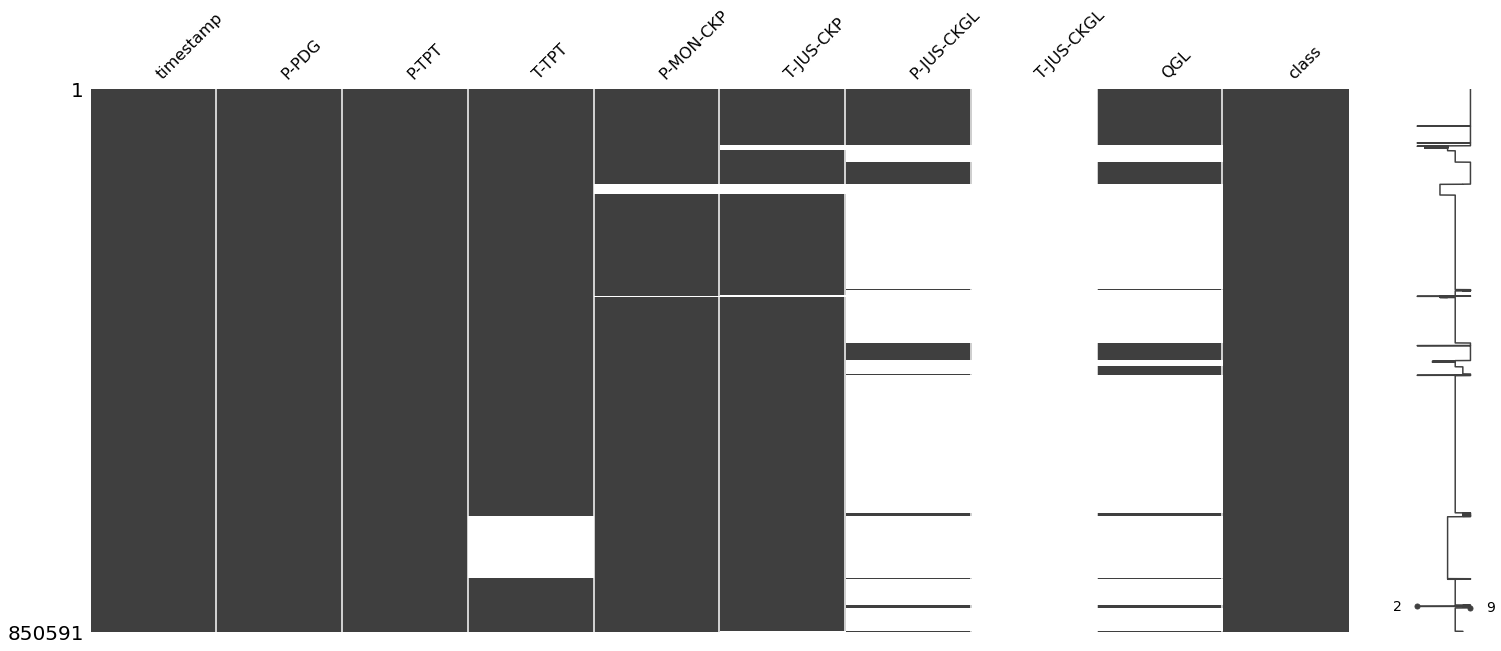

In [6]:
# Disover requencies of misssing data visually
matrix(df)

In [7]:
# Percentage of missing values per column

def per_missing(df):
    '''
    Finds the percentage of missing values in each column
    '''
    tot_len = len(df)
    
    per_missing = df.isna().sum().to_frame()
    per_missing['% missing'] = (per_missing[0]/tot_len) *100
    return per_missing.drop(columns = [0]).sort_values(by = ['% missing'], ascending= False)

per_missing(df)

,% missing
T-JUS-CKGL,100.000000
P-JUS-CKGL,80.130874
QGL,78.775816
T-TPT,11.407715
T-JUS-CKP,3.346262
P-MON-CKP,2.204585
P-TPT,0.008700
P-PDG,0.008347
class,0.004115
timestamp,0.000000


##### There are 3 Columns with alot of missing data(> 50%)
> - P-JUS-CKGL     
> - T-JUS-CKGL     
> - QGL    
Solution - Drop Columns
***

##### Others have just a few(>1% but < 15%>)
> - T-TPT    - check if the missing data are from the same class      
>     - yes , drop columns or drop class(opt)
>     - no  , fill with iterative imputer  
> - P-MON-CKP      
> - T-JUS-CKP  
Solution -  fill missing with Sklearn.iterative_imputer 
***

Also, the class column has some missing column 
Solution - drop rows with missing class
Lets Check the pecentage of missing data in those columns 

In [8]:
# Explore T-TPT columnsdf
missing_T_TPT_class =  df['class'][df['T-TPT'].isna()]
missing_T_TPT_class.value_counts().sort_index()

0.0       6593
3.0          8
4.0          9
6.0      64547
53.0         5
56.0         4
106.0    25862
107.0        5
Name: class, dtype: int64

In [9]:
# We see that the class 6 - Quick Restriction in PCK has alot of missing data
# Our quick guess is to check the percentage of missing data comes from the class = 6

missing_TPT = (64547 + 25862)/(len(df[df['class'] == 6]) + len(df[df['class'] == 106]))

print(f'{(missing_TPT * 100): 1f}% of TPT values that cointains 6 and 106 are missing')

# This simply implies that ue cannot use the T-TPT column if we want to classify the a condition, it will certainly be baised

"""
POSSIBLE SOLUTIONS 
 - Drop all values that cointain 6 or 106, there fore limiting the ability to predict that condition
 - Drop the T-TPT column 
"""
df1 = df.drop(columns=['T-JUS-CKGL','P-JUS-CKGL','QGL','T-TPT'])

 99.637418% of TPT values that cointains 6 or 106 are missing


#### CLEANING CLASS COLUMN

In [10]:
df1['class'].value_counts().sort_index()

0.0      200642
1.0       48495
2.0        6056
3.0       80677
4.0       41477
5.0      176064
6.0       64767
7.0        1812
8.0       10135
50.5          2
51.0          2
52.5          7
53.0          5
54.0          1
55.0          9
56.0          4
101.0     87975
102.0      2446
105.0     40346
106.0     25971
107.0     38365
108.0     25298
Name: class, dtype: int64

In [11]:
#compare the use of foward and backward fill
dfx = df1[['class','timestamp']].copy()
dfx['backfill']  = dfx['class'].fillna(method='backfill')
dfx['ffill']     = dfx['class'].fillna(method='pad')

dfx.iloc[list(df1[df1['class'].isna()].index), -2:]

,backfill,ffill
314811,1.0,101.0
315151,101.0,0.0
315152,101.0,0.0
315153,101.0,0.0
315154,101.0,0.0
315155,101.0,0.0
315156,101.0,0.0
315805,101.0,0.0
315806,101.0,0.0
316157,1.0,101.0


> The nulls, look so much as the transient periods between a normal and a steady state.
> Without much certainty of this is, where this chages resides and considering it is a very minute portion os the data set,
> it would be best to drop nulls

In [12]:
#Find null class --- There are no null classes 
print('There are',df1['class'].isna().sum(), 'missing values in the class column')
print('which is',(df1['class'].isna().sum()/len(df1))*100, 'of the entire data')

There are 35 missing values in the class column
which is 0.004114786072272103 of the entire data


In [13]:
# The classes 10 - 100 are error, considering our class information, so we drop then
# Since class are our target variables, it would not be a great to fill it 
# This also drp the null values
df1  = (df1[(df1['class'] < 10) | (df1['class'] > 100)])

In [14]:
# Filter out all null values 
df1 = df1[df1['class'].notna()]
per_missing(df1)

,% missing
T-JUS-CKP,3.346400
P-MON-CKP,2.204753
P-TPT,0.008700
P-PDG,0.008348
timestamp,0.000000
class,0.000000


##### OUTLIER DETECTION 

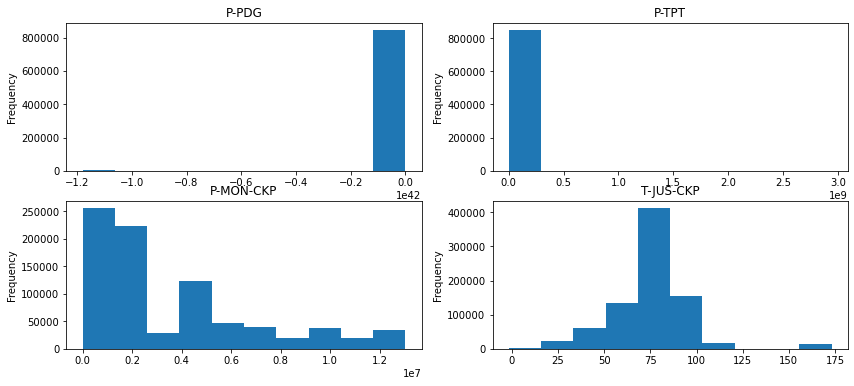

In [15]:
plot_objects = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))
fig, ((ax1, ax2), (ax3, ax4)) = plot_objects

axes_ = (ax1, ax2, ax3, ax4)
for i in enumerate(axes_):
    df1.iloc[: , i[0]+1].plot(kind  = 'hist', 
                          title = df1.columns[i[0]+1] , 
                          ax = i[1])

Consider the __P-PDG__ & __P-TPT__ do not alot of outliers

In [16]:
# FULL DISTRIBUTION
df1[['P-PDG' ,'P-TPT']].quantile(np.linspace(0,1,11))

,P-PDG,P-TPT
0.0,-1.180116e+42,0.000000e+00
0.1,0.000000e+00,8.002606e+06
0.2,2.506680e+02,9.464804e+06
0.3,1.694630e+07,1.210082e+07
0.4,2.031564e+07,1.350474e+07
0.5,2.189268e+07,1.452601e+07
0.6,2.366027e+07,1.566652e+07
0.7,2.520684e+07,1.675082e+07
0.8,2.632614e+07,1.821633e+07
0.9,2.904754e+07,2.077159e+07


In [17]:
# TOP 5 PERCENTILE 
df1[['P-PDG' ,'P-TPT']].quantile(np.linspace(0,0.05,11))


#1% OF THE P-PDG VALUES ARE NECESARRY SKEWED 

,P-PDG,P-TPT
0.000,-1.180116e+42,0.000000
0.005,-6.887865e+06,89.761256
0.010,-6.887865e+06,94.641741
0.015,0.000000e+00,116.256580
0.020,0.000000e+00,135.122100
0.025,0.000000e+00,135.353427
0.030,0.000000e+00,135.724900
0.035,0.000000e+00,136.474718
0.040,0.000000e+00,159.033400
0.045,0.000000e+00,159.676424


In [18]:
# BOTTOM 1 PERCENTILE 
df1[['P-PDG' ,'P-TPT']].quantile(np.linspace(0.99,1,11))

,P-PDG,P-TPT
0.990,4.485805e+07,2.817836e+07
0.991,4.485805e+07,2.822099e+07
0.992,4.485805e+07,2.839609e+07
0.993,4.485805e+07,2.874850e+07
0.994,4.485805e+07,2.911438e+07
0.995,4.485805e+07,2.938450e+07
0.996,4.485805e+07,2.964256e+07
0.997,4.485805e+07,3.026173e+07
0.998,4.485805e+07,3.202548e+07
0.999,4.485805e+07,6.793571e+08


In [19]:
##Clean the data. Filter out OUTLIERS 

df2 = df1[  (df1['P-PDG'] >= df1['P-PDG'].quantile(0.015))
          & (df1['P-PDG'] <= df1['P-PDG'].quantile(0.999))   
          & (df1['P-TPT'] <= df1['P-TPT'].quantile(0.9985))
          ]

In [20]:
## Fill missing wih a bayelsan ridgw regressor usking the sklean.iterative_imputer 

# from sklearn.experimental   import enable_iterative_imputer
# from sklearn.impute         import IterativeImputer
# from catboost               import CatBoostRegressor
# 
# df2 = df2.iloc[:,1:].copy()
# 
# imputer = IterativeImputer( 
#                             verbose   = 2,
#                             max_iter  = 20,
#                             imputation_order = 'ascending'
#                            )
# 
# 
# pd.DataFrame(imputer.fit_transform(df2), columns = df2.columns) # preserve the column name

## Drop all nulls 
df2 = df2.dropna().copy()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809660 entries, 0 to 849070
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  809660 non-null  datetime64[ns]
 1   P-PDG      809660 non-null  float64       
 2   P-TPT      809660 non-null  float64       
 3   P-MON-CKP  809660 non-null  float64       
 4   T-JUS-CKP  809660 non-null  float64       
 5   class      809660 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 43.2 MB


## DATA WRANGLING  & FEATURE EXTRACTION 
- 
> - CONVERT CLASS TO INTEGERS 
> - CONVERT TIMESTAMP TO DATETIME
> - CREATE CLASS_TYPE COLUMN
> - CREATE FAULT_TYPE COLUMN

In [21]:
# CONVERT CLASS TO INTEGERS
df2['class'] = df2['class'].astype(int)

# CONVERT TIMESTAMP TO DATETIME
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

In [22]:
# CREATE CLASS_TYPE COLUMN
def class_type(x):
    if x == 0:
        return 'Normal'
    elif 0 < x < 10:
        return 'Faulty'
    else :
        return 'Transient'
    
df2['Class_type'] = df2['class'].apply(class_type)

In [23]:
faults = {  0:'Normal' ,
            1:'Abrupt Increase of BSW' ,
            2:'Spurious Closure of DHSV' ,
            3:'Severe Slugging' ,
            4:'Flow Instability' ,
            5:'Rapid Productivity Loss' ,
            6:'Quick Restriction  in PCK',
            7:'Scaling in PCK',
            8:'Hydrate in Production Line'}

transient = {101 : 'To Fault 1',  
             102 : 'To Fault 2' , 
             105 : 'To Fault 5',  
             106 : 'To Fault 6',  
             107 : 'To Fault 7',  
             108 : 'To Fault 8',  }

fault_transient  = faults | transient

# CREATE FAULT_TYPE or TRANSIENT TYPE COLUMN
df2['Fault_Type'] = df2['class'].map(fault_transient)

#
df2[['Fault_Type','Class_type']] = df2[['Fault_Type','Class_type']].astype('category')

<a id='eda'></a> 
## EXPLORATORY DATA ANALYSIS 
> - Find class distibution 
> - Use skim to summerize data
> - Find Correlation using heatmap
> - Boxplots 
> - Pairplot to find trends  
> - Consider if ther is are trends with time 

#### How many observation of each class type are there

<AxesSubplot:>

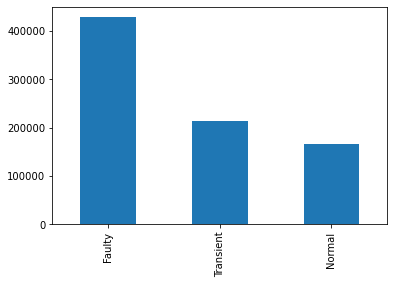

In [24]:
df2['Class_type'].value_counts().plot(kind = 'bar')

### How many observation of each class

<AxesSubplot:title={'center':'Transient Conditions'}>

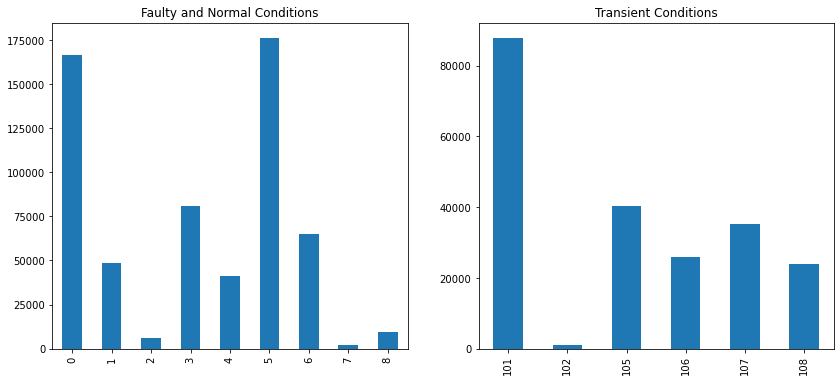

In [25]:
plot_objects = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig, ((ax1, ax2)) = plot_objects

df2['class'][(df2['Class_type'] == 'Faulty') |(df2['Class_type'] == 'Normal') ].value_counts().sort_index().plot(kind = 'bar', 
                                                                                                                 ax   = ax1, 
                                                                                                                title = 'Faulty and Normal Conditions'
                                                                                                                )
df2['class'][df2['Class_type'] == 'Transient'].value_counts().sort_index().plot(kind = 'bar', 
                                                                                ax = ax2,
                                                                                title = 'Transient Conditions'
                                                                                ) 

In [26]:
skim(df2)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types               Categories                                        │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                                │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                                │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                                │
│ │ Number of rows    │ 809660 │ │ float64     │ 4     │ │ Class_type            │                                │
│ │ Number of columns │ 8      │ │ category    │ 2     │ │ Fault_Type            │                                │
│ └───────────────────┴────────┘ │ datetime64  │ 1     │ └───────────────────────┘                                │
│                                │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA  ┃ NA %  ┃ mean       ┃ sd         ┃ p0    ┃ p25       ┃ p75       ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ P-PDG         │   0 │     0 │   19000000 │   12000000 │     0 │  12000000 │  26000000 │  45000000 │ ▅▁▆█▁▁ │  │
│ │ P-TPT         │   0 │     0 │   14000000 │    5700000 │     0 │  11000000 │  18000000 │  32000000 │  ▁▄█▆  │  │
│ │ P-MON-CKP     │   0 │     0 │    3500000 │    3300000 │    10 │   1200000 │   4900000 │  13000000 │ █▃▁▁▁▁ │  │
│ │ T-JUS-CKP     │   0 │     0 │         76 │         22 │  -1.7 │        67 │        85 │       170 │   ▂█▃  │  │
│ │ class         │   0 │     0 │         30 │         45 │     0 │         1 │       100 │       110 │ █    ▃ │  │
│ └───────────────┴─────┴───────┴────────────┴────────────┴───────┴───────────┴───────────┴───────────┴────────┘  │
│                                                    category                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                      ┃ NA        ┃ NA %           ┃ ordered               ┃ unique             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Class_type                       │         0 │              0 │ False                 │                  3 │  │
│ │ Fault_Type                       │         0 │              0 │ False                 │                 15 │  │
│ └──────────────────────────────────┴───────────┴────────────────┴───────────────────────┴────────────────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA   ┃ NA %    ┃ first                      ┃ last                       ┃ frequency    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩  │
│ │ timestamp        │    0 │       0 │    2013-11-04 01:41:00     │    2018-10-07 21:12:00     │ None         │  │
│ └──────────────────┴──────┴─────────┴────────────────────────────┴────────────────────────────┴──────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

#### Correlation strenghts of each feature

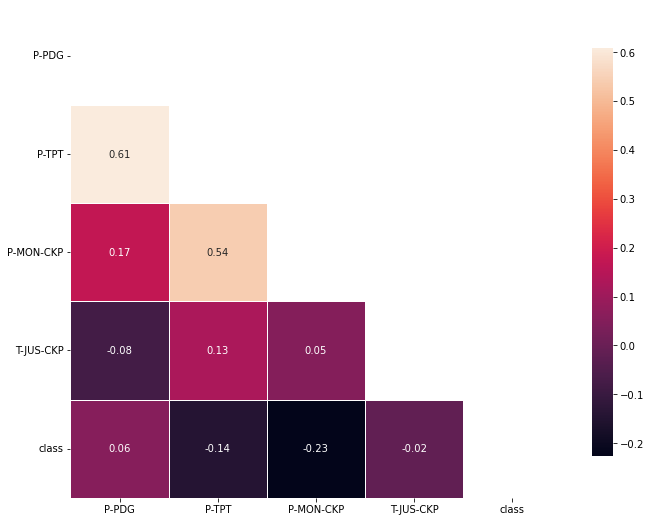

In [27]:
##create correlation table 
df_corr = df2.corr()

##create mask to remove upper boundaries 
mask = np.zeros_like(df_corr, dtype = bool)
mask[np.triu_indices_from(mask)]= True

##plot heatmap
f, ax = plt.subplots(figsize=(11, 15))
sns.heatmap(df_corr, annot=True, fmt='.2f', mask=mask, 
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
#add the column names as labels
ax.set_yticklabels(df_corr.columns, rotation = 0)
ax.set_xticklabels(df_corr.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

### DISTRIBUTION OF VALUES

<AxesSubplot:xlabel='Class_type', ylabel='T-JUS-CKP'>

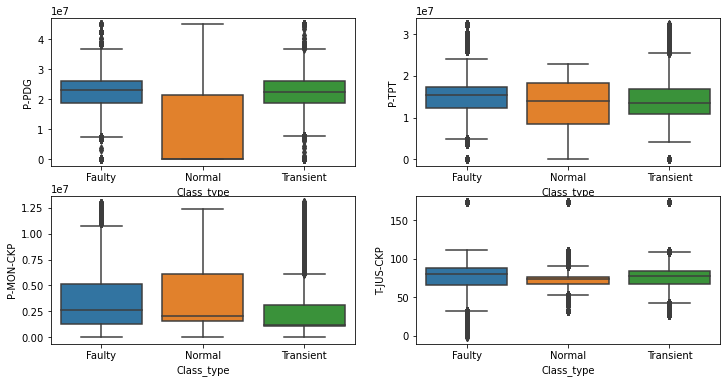

In [28]:
#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12,6))

#create boxplot in each subplot
sns.boxplot(data = df2 , y = 'P-PDG',    x = 'Class_type',  ax=axes[0,0])
sns.boxplot(data = df2 , y = 'P-TPT',    x = 'Class_type',  ax=axes[0,1])
sns.boxplot(data = df2 , y = 'P-MON-CKP',x = 'Class_type',  ax=axes[1,0])
sns.boxplot(data = df2 , y = 'T-JUS-CKP',x = 'Class_type',  ax=axes[1,1])

### Kernel Distribution Estimate visualizing the distribution of observations in a dataset 

<AxesSubplot:xlabel='T-JUS-CKP', ylabel='Density'>

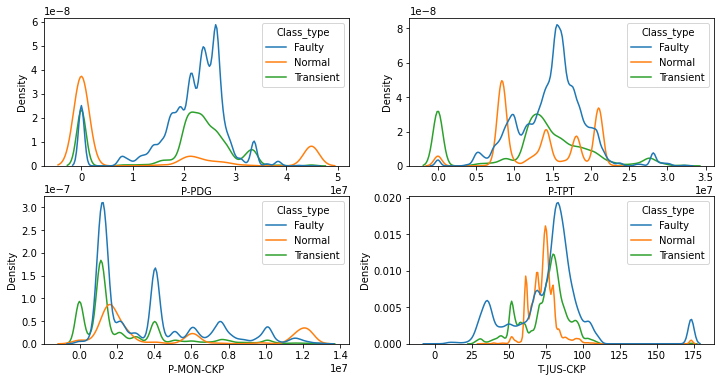

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
sns.kdeplot(data=df2, x="P-PDG",     hue="Class_type", ax=axes[0,0])
sns.kdeplot(data=df2, x="P-TPT",     hue="Class_type", ax=axes[0,1])
sns.kdeplot(data=df2, x="P-MON-CKP", hue="Class_type", ax=axes[1,0])
sns.kdeplot(data=df2, x="T-JUS-CKP", hue="Class_type", ax=axes[1,1])

Estimator of the Cumulative Distribution Function. The ECDF essentially allows you to plot a feature of your data in order from least to greatest and see the whole feature as if is distributed across the data set

<AxesSubplot:xlabel='T-JUS-CKP', ylabel='Proportion'>

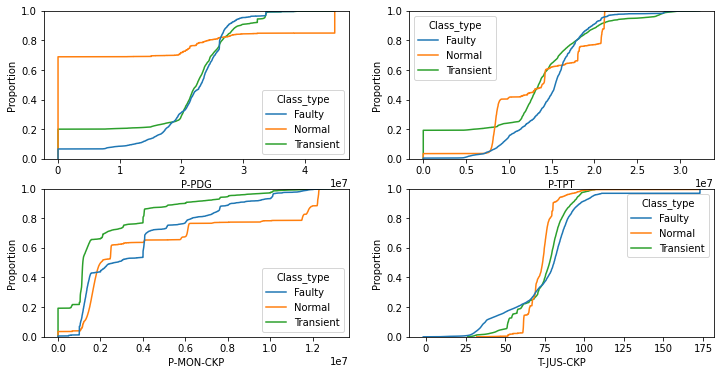

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
sns.ecdfplot(data = df2, x = "P-PDG",     hue = "Class_type", ax = axes[0,0])
sns.ecdfplot(data = df2, x = "P-TPT",     hue = "Class_type", ax = axes[0,1])
sns.ecdfplot(data = df2, x = "P-MON-CKP", hue = "Class_type", ax = axes[1,0])
sns.ecdfplot(data = df2, x = "T-JUS-CKP", hue = "Class_type", ax = axes[1,1])

### Plot relationships between Features

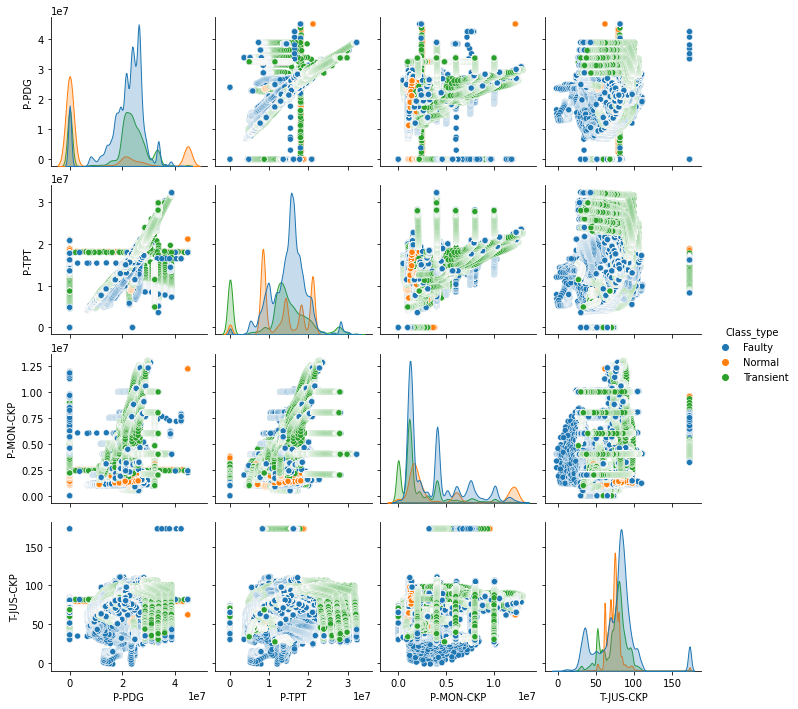

In [31]:
Columns = list(df2.columns)
sns.pairplot(data = df2[Columns[:7]].drop(["class", 'timestamp'], axis="columns"), 
              hue = "Class_type")

<a id='mdd'></a>
## Model Development

We are developing Three models. Class type, Transient and faulty. 
the Class type predicts the state of the well if the state of the well is either Transient of faulty, the Transient Model or Faulty Model predicts the fault of the well
> - Choose NN architecture
> - Normalization 
> - Create dense layers(Optional add Dropout and batch normalization layers)
> - Evaluate and tune hyper-parameters

### Choosen DNN architecture 

<img src="DNN architecture.jpg">

### Split data into
- Train          60%
- Test           20%
- Validation       20%


In [33]:
class_type2int = {'Normal': 0 , 'Transient':1, 'Faulty':2 }

X_train, X_test, y_train, y_test = train_test_split( df2.iloc[:, 1:5], 
                                                    df2['Class_type'].map(class_type2int), 
                                                    train_size   =  0.6, 
                                                    random_state =  4)
X_test, X_CV, y_test, y_CV = train_test_split( X_test, 
                                               y_test,
                                               test_size = 0.5, 
                                               random_state = 4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:',  X_test.shape,  y_test.shape)
print ('Cross Validation set:', X_CV.shape,  y_CV.shape)

Train set: (485796, 4) (485796,)
Test set: (161932, 4) (161932,)
Cross Validation set: (161932, 4) (161932,)


### Create Normalizer
Considering the magnitude of the value, the most efficetive direction is to scale down the values.

This is what a normalizer does. It is similar to the standard scaler in the sklearn libary


In [ ]:
normalizer = Normalization(axis=-1)                       # Normalize along rows
normalizer.adapt(tf.convert_to_tensor(df2.iloc[:, 1:5]))  # Train the normalizer on the input data 

In [71]:
# Create DNN of choose architecture 

model1 = Sequential(
    [   normalizer ,
        Dense(64,  activation = 'relu',   name = "L1"),
        Dense(64, activation  = 'relu',    name = "L2"),
        Dropout(0.25),
        Dense(32, activation  = 'relu',    name = "L3"),
        Dense(16, activation  = 'relu',    name = "L4"),
        Dense(3,  activation  = 'softmax', name = "CC")
    ]   )


model1.compile (
    loss     = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(),
                )

In [109]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 4)                9         
 ion)                                                            
                                                                 
 L1 (Dense)                  (None, 64)                320       
                                                                 
 L2 (Dense)                  (None, 64)                4160      
                                                                 
 L3 (Dense)                  (None, 32)                2080      
                                                                 
 L4 (Dense)                  (None, 16)                528       
                                                                 
 CC (Dense)                  (None, 3)                 51        
                                                      

In [ ]:
tf.keras.utils.plot_model(ClassType, "Class Type.png", show_shapes = True)

In [108]:
model1.fit(
    X_train,y_train,
    epochs = 200,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor ="loss", 
                                             mode = "min", 
                                             patience = 5, 
                                             restore_best_weights = True)  #STOPS MODEL FROM OVERTRAINING  
    )

plt.plot(model1.history.history['loss'])

Epoch 1/30
15182/15182 [==============================] - 32s 2ms/step - loss: 0.2126
Epoch 2/30
15182/15182 [==============================] - 33s 2ms/step - loss: 0.2124
Epoch 3/30
15182/15182 [==============================] - 33s 2ms/step - loss: 0.2123
Epoch 4/30
15182/15182 [==============================] - 34s 2ms/step - loss: 0.2113
Epoch 5/30
15182/15182 [==============================] - 32s 2ms/step - loss: 0.2108
Epoch 6/30
15182/15182 [==============================] - 31s 2ms/step - loss: 0.2102
Epoch 7/30
15182/15182 [==============================] - 31s 2ms/step - loss: 0.2095
Epoch 8/30
15182/15182 [==============================] - 31s 2ms/step - loss: 0.2101
Epoch 9/30
15182/15182 [==============================] - 32s 2ms/step - loss: 0.2094
Epoch 10/30
15182/15182 [==============================] - 30s 2ms/step - loss: 0.2084
Epoch 11/30
15182/15182 [==============================] - 31s 2ms/step - loss: 0.2080
Epoch 12/30
15182/15182 [===========================

### MODEL EVALUATION

In [59]:
def draw_confusion_matrix(cm):
    "PLOTS A HEATMAP OF THE PREDICTION"
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
def nnmodel_predict(Model, X_train):
    'CHECKS THE ACCURACY OF MODEL'
    prediction = Model.predict(X_train)
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction, axis=1)
    return yhat

def accuracy_metrics(y_train, yhat):
    print(f" the accuarcy of the model is {accuracy_score(y_train, yhat)} \n")
    print(f" the F1 score of the mdel is {f1_score(y_train, yhat, average='weighted')} \n") 
    print(f" the jaccard score of the model is {jaccard_score(y_train, yhat, average='weighted')}\n")
    print(classification_report(y_train, yhat))
    cm = confusion_matrix(y_train,yhat)
    draw_confusion_matrix(cm)

### TRAIN SET

In [110]:
yhat_train = nnmodel_predict(model1, X_train)

15182/15182 [==============================] - 22s 1ms/step


 the accuarcy of the model is 0.9285234954589993 

 the F1 score of the mdel is 0.9283331449666119 

 the jaccard score of the model is 0.8673539927834453

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     99733
           1       0.89      0.88      0.89    128381
           2       0.93      0.96      0.95    257682

    accuracy                           0.93    485796
   macro avg       0.93      0.91      0.92    485796
weighted avg       0.93      0.93      0.93    485796



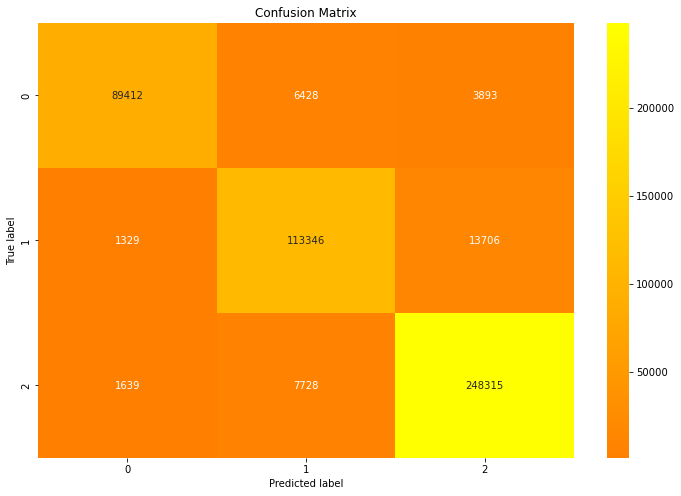

In [111]:
accuracy_metrics(y_train, yhat_train)

###  CROSS VALIDATION SET

In [112]:
y_hat_CV = nnmodel_predict(model1, X_CV)

5061/5061 [==============================] - 8s 2ms/step


 the accuarcy of the model is 0.9280870982881704 

 the F1 score of the mdel is 0.9279340223659694 

 the jaccard score of the model is 0.8666418773834624

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     33486
           1       0.89      0.88      0.89     42983
           2       0.93      0.96      0.95     85463

    accuracy                           0.93    161932
   macro avg       0.93      0.91      0.92    161932
weighted avg       0.93      0.93      0.93    161932



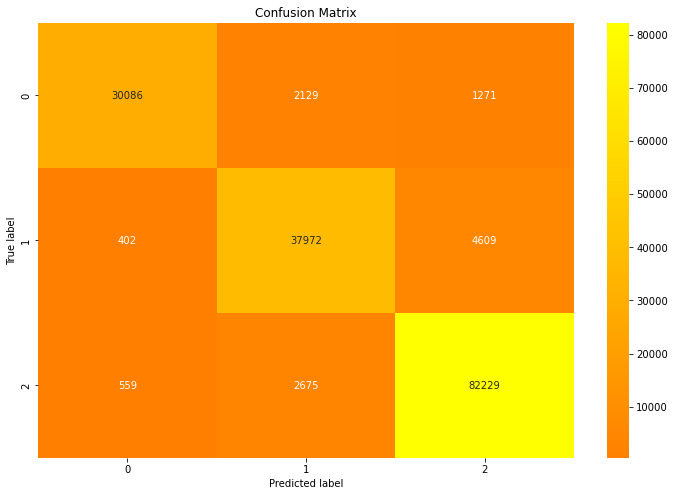

In [113]:
accuracy_metrics(y_CV, y_hat_CV)

### TEST SET

In [114]:
y_hat_test = nnmodel_predict(model1, X_test)

5061/5061 [==============================] - 8s 2ms/step


 the accuarcy of the model is 0.9269508188622385 

 the F1 score of the mdel is 0.9267919038333571 

 the jaccard score of the model is 0.8646897188286959

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     33337
           1       0.89      0.88      0.88     42933
           2       0.93      0.96      0.95     85662

    accuracy                           0.93    161932
   macro avg       0.93      0.91      0.92    161932
weighted avg       0.93      0.93      0.93    161932



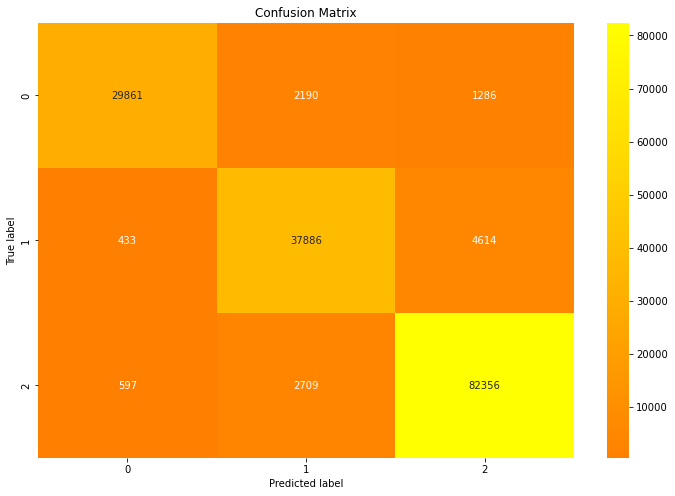

In [115]:
accuracy_metrics(y_test, y_hat_test)

In [117]:
df2_Transient = df2.query("Class_type == 'Transient'")
df2_Fault = df2.query("Class_type == 'Faulty'")

### Model 2
MOdel 2 Predicts the type of transient condition

In [127]:
# SPLIT INTO TEST, TRAINING AND VALIDATION SETS 
transient_type2int = {  'To Fault 1': 0,  
                        'To Fault 2': 1 , 
                        'To Fault 3': 2,  
                        'To Fault 6': 3,  
                        'To Fault 7': 4,  
                        'To Fault 8': 5,  }

X_train, X_test, y_train, y_test = train_test_split( df2_Transient.iloc[:, 1:4], 
                                                    df2_Transient['Fault_Type'].map(transient_type2int), 
                                                    train_size   =  0.6, 
                                                    random_state =  4)
X_test, X_CV, y_test, y_CV = train_test_split( X_test, 
                                               y_test,
                                               test_size = 0.5, 
                                               random_state = 4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:',  X_test.shape,  y_test.shape)
print ('Cross Validation set:', X_CV.shape,  y_CV.shape)

Train set: (128578, 3) (128578,)
Test set: (42859, 3) (42859,)
Cross Validation set: (42860, 3) (42860,)


In [131]:
# Create DNN of choose architecture 

tf.random.set_seed(1234)  # applied to achieve consistent results


normalizer = Normalization(axis=-1) # Normalize along rows
normalizer.adapt(tf.convert_to_tensor(df2_Transient.iloc[:, 1:4]))              # Train the normalizer on the input data 

model2 = Sequential(
    [normalizer,
    Dense(64,  activation  = 'relu',   name = "L1"),
    Dense(64, activation  = 'relu',    name = "L2"),
    Dropout(0.25),
    Dense(32, activation  = 'relu',    name = "L3"),
    Dense(16, activation  = 'relu',    name = "L4"),
    Dense(6,  activation  = 'softmax', name = "CC")
    ]            )

model2.compile (
    loss     = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(),
                )

In [139]:
model2.fit(
    X_train, y_train,
    epochs = 200,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor ="loss", 
                                    mode ="min", patience = 5, 
                                    restore_best_weights = True)
    )

Epoch 1/50
4019/4019 [==============================] - 8s 2ms/step - loss: 0.1149
Epoch 2/50
4019/4019 [==============================] - 9s 2ms/step - loss: 0.1131
Epoch 3/50
4019/4019 [==============================] - 8s 2ms/step - loss: 0.1121
Epoch 4/50
4019/4019 [==============================] - 8s 2ms/step - loss: 0.1126
Epoch 5/50
4019/4019 [==============================] - 9s 2ms/step - loss: 0.1131
Epoch 6/50
4019/4019 [==============================] - 9s 2ms/step - loss: 0.1122
Epoch 7/50
4019/4019 [==============================] - 9s 2ms/step - loss: 0.1112
Epoch 8/50
4019/4019 [==============================] - 8s 2ms/step - loss: 0.1110
Epoch 9/50
4019/4019 [==============================] - 8s 2ms/step - loss: 0.1102
Epoch 10/50
4019/4019 [==============================] - 10s 2ms/step - loss: 0.1099
Epoch 11/50
4019/4019 [==============================] - 9s 2ms/step - loss: 0.1102
Epoch 12/50
4019/4019 [==============================] - 9s 2ms/step - loss: 0.1095


In [140]:
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_11 (Normaliza  (None, 3)                7         
 tion)                                                           
                                                                 
 L1 (Dense)                  (None, 64)                256       
                                                                 
 L2 (Dense)                  (None, 64)                4160      
                                                                 
 L3 (Dense)                  (None, 32)                2080      
                                                                 
 L4 (Dense)                  (None, 16)                528       
                                                                 
 CC (Dense)                  (None, 6)                 102       
                                                      

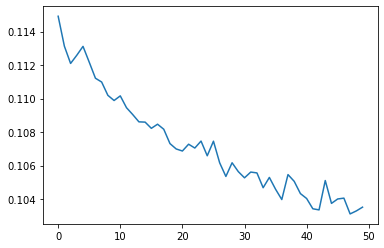

In [141]:
plt.plot(model2.history.history["loss"])

### TRAIN SET

4019/4019 [==============================] - 6s 1ms/step
 the accuarcy of the model is 0.9582821322465741 

 the F1 score of the mdel is 0.9591141228293122 

 the jaccard score of the model is 0.9226748409650339

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     52542
         1.0       1.00      0.98      0.99       667
         2.0       1.00      0.96      0.98     24251
         3.0       0.95      0.99      0.97     15536
         4.0       0.83      1.00      0.91     21161
         5.0       1.00      1.00      1.00     14421

    accuracy                           0.96    128578
   macro avg       0.96      0.97      0.97    128578
weighted avg       0.96      0.96      0.96    128578



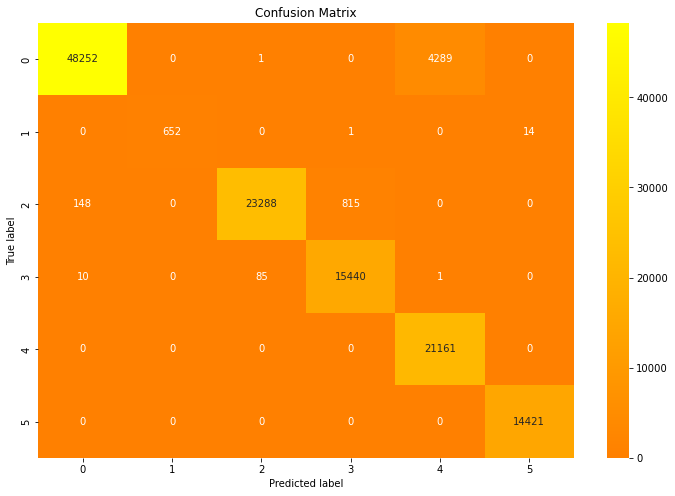

In [142]:
yhat_train = nnmodel_predict(model2, X_train)
accuracy_metrics(y_train, yhat_train)

### CROSS VALIDATION SET

1340/1340 [==============================] - 2s 1ms/step
 the accuarcy of the model is 0.9563229118058796 

 the F1 score of the mdel is 0.9571674971827404 

 the jaccard score of the model is 0.9190167843786117

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     17577
         1.0       1.00      0.98      0.99       215
         2.0       1.00      0.95      0.97      7994
         3.0       0.94      0.99      0.97      5204
         4.0       0.83      1.00      0.91      7067
         5.0       1.00      1.00      1.00      4803

    accuracy                           0.96     42860
   macro avg       0.96      0.97      0.96     42860
weighted avg       0.96      0.96      0.96     42860



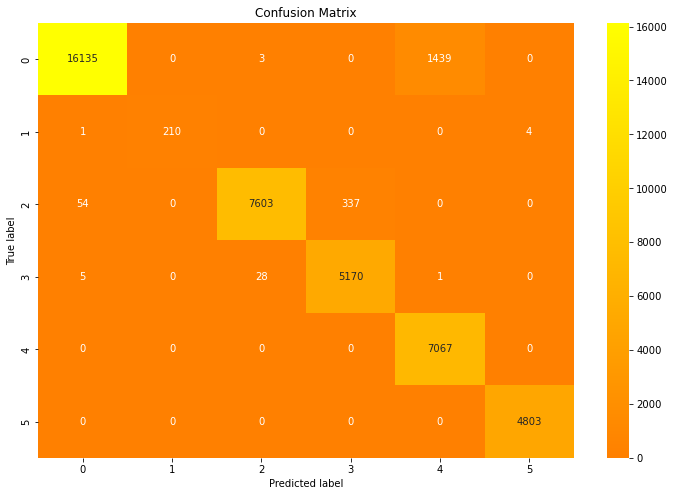

In [143]:
yhat_CV = nnmodel_predict(model2, X_CV)
accuracy_metrics(y_CV, yhat_CV)

### TEST SET

1340/1340 [==============================] - 2s 1ms/step
 the accuarcy of the model is 0.9564385543293124 

 the F1 score of the mdel is 0.9573730840892725 

 the jaccard score of the model is 0.9195950008596292

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95     17688
         1.0       1.00      0.96      0.98       234
         2.0       1.00      0.96      0.98      8011
         3.0       0.95      1.00      0.97      5231
         4.0       0.82      1.00      0.90      7009
         5.0       1.00      1.00      1.00      4686

    accuracy                           0.96     42859
   macro avg       0.96      0.97      0.96     42859
weighted avg       0.96      0.96      0.96     42859



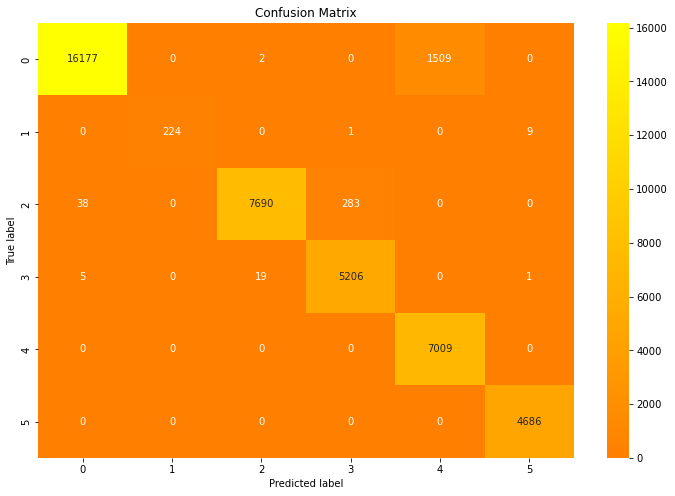

In [144]:
yhat_test = nnmodel_predict(model2, X_test)
accuracy_metrics(y_test, yhat_test)

### Model 3

In [146]:
faults_type2int = { 'Normal'                    : 0 ,
                    'Abrupt Increase of BSW'    : 1 ,
                    'Spurious Closure of DHSV'  : 2 ,
                    'Severe Slugging'           : 3 ,
                    'Flow Instability'          : 4 ,
                    'Rapid Productivity Loss'   : 5 ,
                    'Quick Restriction  in PCK' : 6 ,
                    'Scaling in PCK'            : 7 ,
                    'Hydrate in Production Line': 8 }

X_train, X_test, y_train, y_test = train_test_split( df2_Fault.iloc[:, 1:4], 
                                                    df2_Fault['Fault_Type'].map(faults_type2int), 
                                                    train_size   =  0.6, 
                                                    random_state =  4)
X_test, X_CV, y_test, y_CV = train_test_split( X_test, 
                                               y_test,
                                               test_size = 0.5, 
                                               random_state = 4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:',  X_test.shape,  y_test.shape)
print ('Cross Validation set:', X_CV.shape,  y_CV.shape)

Train set: (257284, 3) (257284,)
Test set: (85761, 3) (85761,)
Cross Validation set: (85762, 3) (85762,)


In [150]:
# Create DNN of choose architecture 

tf.random.set_seed(1234)  # applied to achieve consistent results


normalizer = Normalization(axis=-1) # Normalize along rows
normalizer.adapt(tf.convert_to_tensor(df2_Fault.iloc[:, 1:4]))              # Train the normalizer on the input data 

model3 = Sequential(
    [   normalizer,
        Dense(64,  activation  = 'relu',   name = "L1"),
        Dense(64, activation  = 'relu',    name = "L2"),
        Dropout(0.25),
        Dense(32, activation  = 'relu',    name = "L3"),
        Dense(16, activation  = 'relu',    name = "L4"),
        Dense(9,  activation  = 'softmax', name = "CC")          
    ]             )

model3.compile (
    loss     = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(),
                )

In [152]:
model3.fit(
    X_train, y_train,
    epochs = 200,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor ="loss", 
                                    mode ="min", patience = 5, 
                                    restore_best_weights = True)
    )

Epoch 1/100
8041/8041 [==============================] - 19s 2ms/step - loss: 0.3053
Epoch 2/100
8041/8041 [==============================] - 17s 2ms/step - loss: 0.1537
Epoch 3/100
8041/8041 [==============================] - 17s 2ms/step - loss: 0.1132
Epoch 4/100
8041/8041 [==============================] - 17s 2ms/step - loss: 0.0882
Epoch 5/100
8041/8041 [==============================] - 18s 2ms/step - loss: 0.0763
Epoch 6/100
8041/8041 [==============================] - 17s 2ms/step - loss: 0.0679
Epoch 7/100
8041/8041 [==============================] - 17s 2ms/step - loss: 0.0633
Epoch 8/100
8041/8041 [==============================] - 17s 2ms/step - loss: 0.0602
Epoch 9/100
8041/8041 [==============================] - 17s 2ms/step - loss: 0.0561
Epoch 10/100
8041/8041 [==============================] - 17s 2ms/step - loss: 0.0534
Epoch 11/100
8041/8041 [==============================] - 17s 2ms/step - loss: 0.0509
Epoch 12/100
8041/8041 [==============================] - 17s 2

In [153]:
model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_13 (Normaliza  (None, 3)                7         
 tion)                                                           
                                                                 
 L1 (Dense)                  (None, 64)                256       
                                                                 
 L2 (Dense)                  (None, 64)                4160      
                                                                 
 L3 (Dense)                  (None, 32)                2080      
                                                                 
 L4 (Dense)                  (None, 16)                528       
                                                                 
 CC (Dense)                  (None, 9)                 153       
                                                     

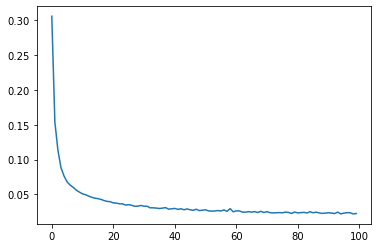

In [154]:
plt.plot(model3.history.history["loss"])

### Model 3 Evaluation

### Train set

8041/8041 [==============================] - 11s 1ms/step
 the accuarcy of the model is 0.992486901633992 

 the F1 score of the mdel is 0.9925584680092107 

 the jaccard score of the model is 0.9853432984389787

              precision    recall  f1-score   support

         1.0       1.00      0.99      0.99     28895
         2.0       1.00      1.00      1.00      3534
         3.0       1.00      0.99      0.99     48384
         4.0       0.97      1.00      0.99     24873
         5.0       1.00      0.99      1.00    105635
         6.0       0.99      0.99      0.99     39006
         7.0       0.79      0.99      0.88      1073
         8.0       1.00      1.00      1.00      5884

    accuracy                           0.99    257284
   macro avg       0.97      0.99      0.98    257284
weighted avg       0.99      0.99      0.99    257284



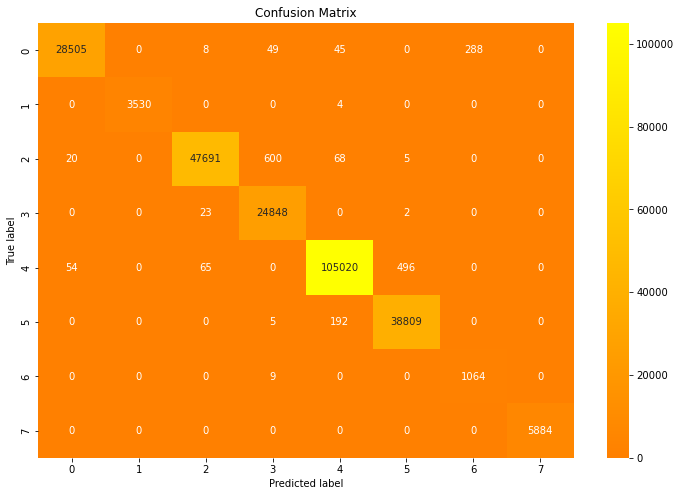

In [155]:
yhat_train = nnmodel_predict(model3, X_train)
accuracy_metrics(y_train, yhat_train)


### Cross Validation

2681/2681 [==============================] - 5s 2ms/step
 the accuarcy of the model is 0.9921293813110702 

 the F1 score of the mdel is 0.9921985607998078 

 the jaccard score of the model is 0.984625250682318

              precision    recall  f1-score   support

         1.0       1.00      0.99      0.99      9745
         2.0       1.00      1.00      1.00      1183
         3.0       1.00      0.98      0.99     16237
         4.0       0.97      1.00      0.99      8320
         5.0       1.00      0.99      1.00     35184
         6.0       0.99      0.99      0.99     12831
         7.0       0.79      1.00      0.88       351
         8.0       1.00      1.00      1.00      1911

    accuracy                           0.99     85762
   macro avg       0.97      0.99      0.98     85762
weighted avg       0.99      0.99      0.99     85762



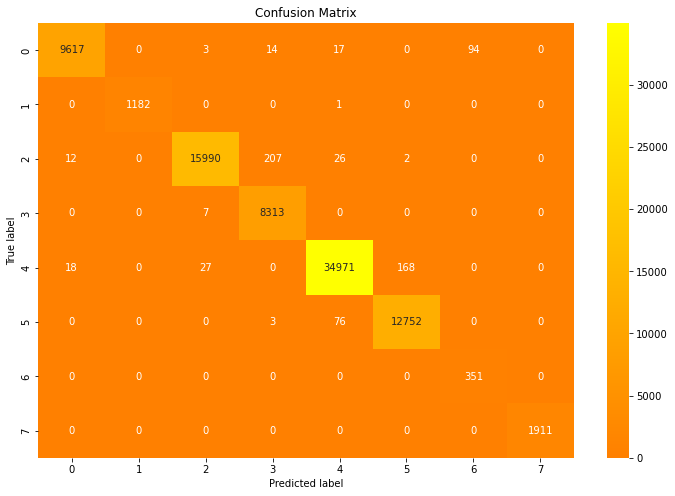

In [156]:
yhat_CV = nnmodel_predict(model3, X_CV)
accuracy_metrics(y_CV, yhat_CV)


### Test

2681/2681 [==============================] - 4s 2ms/step
 the accuarcy of the model is 0.9924790988911043 

 the F1 score of the mdel is 0.992525269589747 

 the jaccard score of the model is 0.9852440675645304

              precision    recall  f1-score   support

         1.0       1.00      0.99      0.99      9855
         2.0       1.00      1.00      1.00      1091
         3.0       1.00      0.99      0.99     16048
         4.0       0.97      1.00      0.99      8273
         5.0       1.00      0.99      1.00     35245
         6.0       0.99      1.00      0.99     12930
         7.0       0.83      0.99      0.90       388
         8.0       1.00      1.00      1.00      1931

    accuracy                           0.99     85761
   macro avg       0.97      0.99      0.98     85761
weighted avg       0.99      0.99      0.99     85761



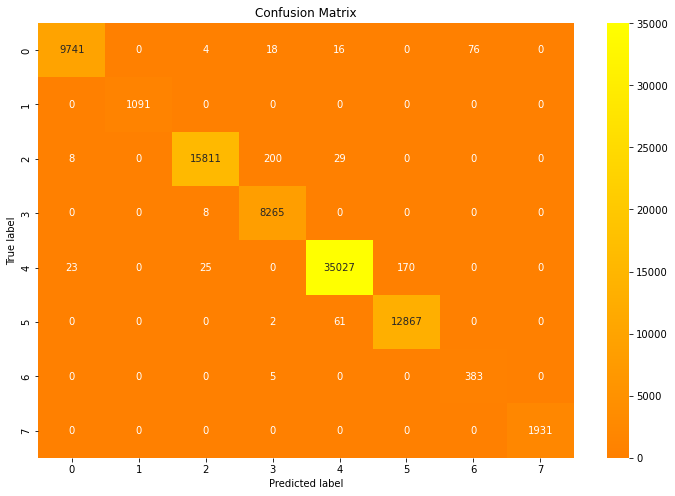

In [157]:
yhat_test = nnmodel_predict(model3, X_test)
accuracy_metrics(y_test, yhat_test)

In [159]:
model1.save("ClassModel")
model2.save("TransientModel")
model3.save("FaultyModel")

INFO:tensorflow:Assets written to: TransientModel\assets


INFO:tensorflow:Assets written to: TransientModel\assets
